# Let's first look at the raw (un-interpolated) MPAS output

In [1]:
from mpasoutput import MPASraw   # xarray-based class for MPAS output
from datetime import datetime
import xarray
import numpy as np

# Let's only keep a few variables: mesh info variables, and temp/precip/moisture
ds = xarray.open_dataset('/glade/scratch/njweber2/experiments/24km_4day_20170401/diag.2017-04-01_12.00.00.nc')
allvars = [ds.data_vars[key].name for key in ds.data_vars.keys()]
del ds
#          mesh info            desired plotting variables
keepvars = allvars[1:29] + ['t2m', 'mslp', 'rainc', 'rainnc','precipw']
dropvars = [var for var in allvars if var not in keepvars]


# Load the forecast output
workdir = '/glade/scratch/njweber2/experiments/24km_4day_20170401'
mpas_fcst = MPASraw.from_netcdf(workdir, datetime(2017,4,1,0), 1, dropvars=dropvars)
# Convert t2m to Celsius and pressure to hPa
mpas_fcst['t2m'] -= 273.15
mpas_fcst['mslp'] /= 100.

In [2]:
# Calculate hourly and 3-hourly precip amounts
mpas_fcst.compute_preciprate(dt=1)
mpas_fcst.compute_preciprate(dt=3)

Created new variable: "prate1h"
Created new variable: "prate3h"


In [3]:
# Compute global means of precip and moisture
mean_1hprate = mpas_fcst.compute_globalmean('prate1h')
mean_3hprate = mpas_fcst.compute_globalmean('prate3h')
mean_pwat = mpas_fcst.compute_globalmean('precipw')

## Globally averaged (area-weighted) precip rate and precipitable water

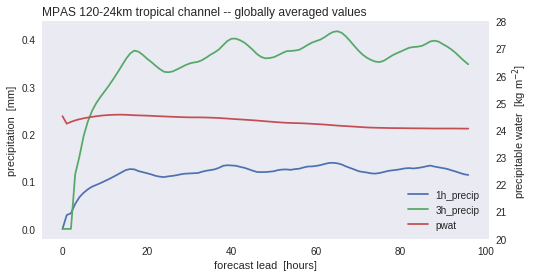

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns     # fancy plots
colors = sns.color_palette()

fig, ax1 = plt.subplots(figsize=(8,4))
x = mpas_fcst.leadtimes()
ln1 = ax1.plot(x, mean_1hprate.values, color=colors[0], label='1h_precip')
ln2 = ax1.plot(x, mean_3hprate.values, color=colors[1], label='3h_precip')
ax1.set_xlabel('forecast lead  [hours]')
ax1.set_ylabel('precipitation  [mm]')
ax1.grid('off')
ax2 = ax1.twinx()
ln3 = ax2.plot(x, mean_pwat, color=colors[2], label='pwat')
ax2.set_ylabel('precipitable water  [kg m$^{-2}$]')
ax2.set_ylim(20, 28)
ax2.grid('off')
ax1.set_title('MPAS 120-24km tropical channel -- globally averaged values', loc='left')
lns = ln1+ln2+ln3
labs = [l.get_label() for l in lns]
ax1.legend(lns, labs, loc='best')
plt.show()

Here's how the MPAS global precip compares to the annual global mean daily precip (1979-2010) from GPCP (https://climatedataguide.ucar.edu/climate-data/gpcp-monthly-global-precipitation-climatology-project)

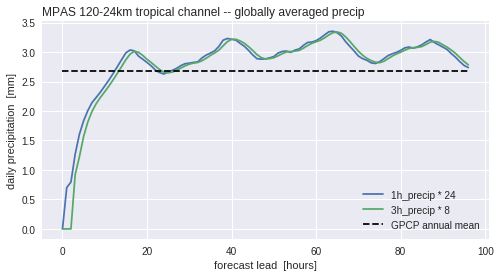

In [5]:
fig, ax = plt.subplots(figsize=(8,4))
ax.plot(x, mean_1hprate.values*24, color=colors[0], label='1h_precip * 24')
ax.plot(x, mean_3hprate.values*8, color=colors[1], label='3h_precip * 8')
ax.plot([x[0],x[-1]], [2.67, 2.67], color='k', linestyle='--', label='GPCP annual mean')
ax.set_xlabel('forecast lead  [hours]')
ax.set_ylabel('daily precipitation  [mm]')
ax.set_title('MPAS 120-24km tropical channel -- globally averaged precip', loc='left')
ax.legend(loc='best')
plt.show()

## Forecast meteorogram near Madison, WI

Fetching data at 43.07N 270.82E
Fetching data at 43.07N 270.82E
Fetching data at 43.07N 270.82E


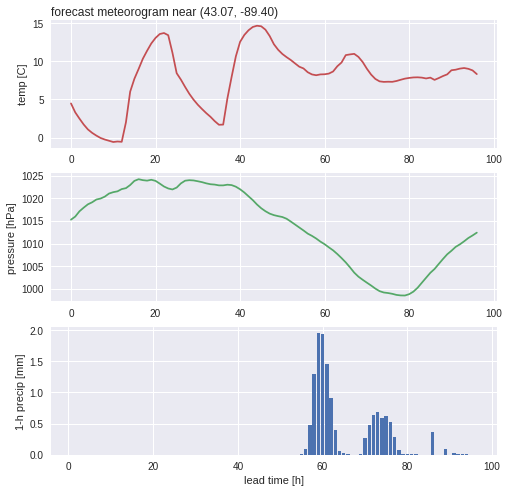

In [6]:
pt = (43.0731, -89.4012)  # Madison, WI
x = mpas_fcst.leadtimes()
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(8,8))
# temp
axes[0].plot(x, mpas_fcst.get_timeseries('t2m', pt), color=colors[2])
axes[0].set_ylabel('temp [C]')
axes[0].text(0., 1.01, 'forecast meteorogram near ({:.02f}, {:.02f})'.format(pt[0],pt[1]),
             transform=axes[0].transAxes, ha='left', va='bottom')
# pressure
axes[1].plot(x, mpas_fcst.get_timeseries('mslp', pt), color=colors[1])
axes[1].set_ylabel('pressure [hPa]')
# pressure
axes[2].bar(x, mpas_fcst.get_timeseries('prate1h', pt), color=colors[0])
axes[2].set_ylabel('1-h precip [mm]')
axes[2].set_xlabel('lead time [h]')
plt.show()

## Terrain, 2-meter temp, and precip on the native mesh

Created new variable: "ter"


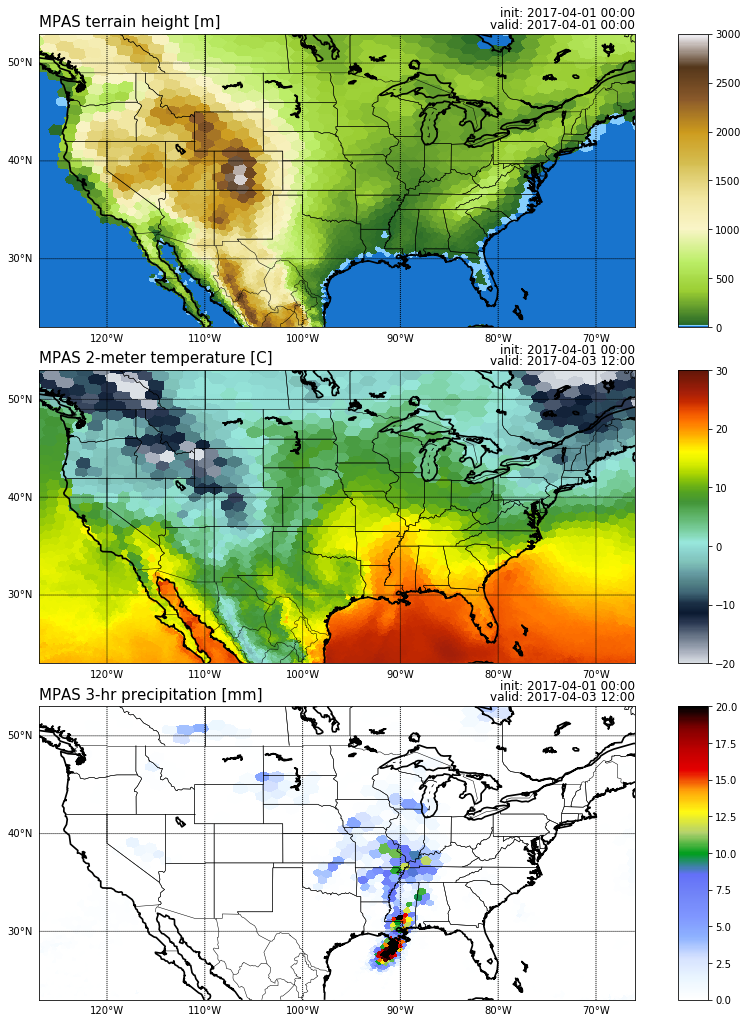

In [7]:
from plotting_mpas_mesh import draw_fig_axes, pcolor_on_mesh  # functions for MPASraw class
from color_maker.color_maker import color_map   # local, custom colormaps
from mpl_toolkits.axes_grid1 import make_axes_locatable
import my_map_projections as mymaps   # local, custom map projections
sns.reset_orig() # restore normal matplotlib rc parameters

# Make sure we have terrain info
if 'ter' not in mpas_fcst.variables.keys():
    mpas_fcst.get_terrain()
    
# Make our figures, axes, and Basemaps
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12,18))
fig.subplots_adjust(hspace=0.1)
ms = []
caxes = []
for a, ax in enumerate(axes):
    ms.append(mymaps.draw_projection(ax, 'cylCONUS', mapcol='k'))
    divider = make_axes_locatable(ax)
    caxes.append(divider.append_axes('right', size='5%', pad=0.6))

# Now plot the data
picklefile = '{}/cyl_conus_24k_mesh.pckl'.format(workdir)
pcolor_on_mesh(ms[0], axes[0], caxes[0], mpas_fcst, title='MPAS terrain height [m]',
               picklefile=picklefile)
pcolor_on_mesh(ms[1], axes[1], caxes[1], mpas_fcst, var='t2m', vmin=-20., vmax=30., time=60,
               cmap=color_map('ncar_temp'), title='MPAS 2-meter temperature [C]',
               picklefile=picklefile)
pcolor_on_mesh(ms[2], axes[2], caxes[2], mpas_fcst, var='prate3h', vmin=0., vmax=20., time=60,
               cmap=color_map('ncar_precip'), title='MPAS 3-hr precipitation [mm]',
               picklefile=picklefile)
plt.show()

# NOTE: may not work for all map projections... I tried with a stereographic projection and
#       strange artifacts appeared in the data.

# Now let's work with post-processed (interpolated) MPAS output

In [8]:
from mpasoutput import MPASprocessed
del mpas_fcst
# this MPAS file was create using Michael Duda's convert_mpas utility
# "./convert_mpas tropical_24km.init.nc diag.*.nc"  (produced file "latlon.nc" which I renamed)
ncfile = '{}/diags.latlon.nc'.format(workdir)
mpas_fcst = MPASprocessed.from_netcdf(ncfile, datetime(2017,4,1,0), 1)

## Some simple contour/fill plots

Created new variable: "prate3h"


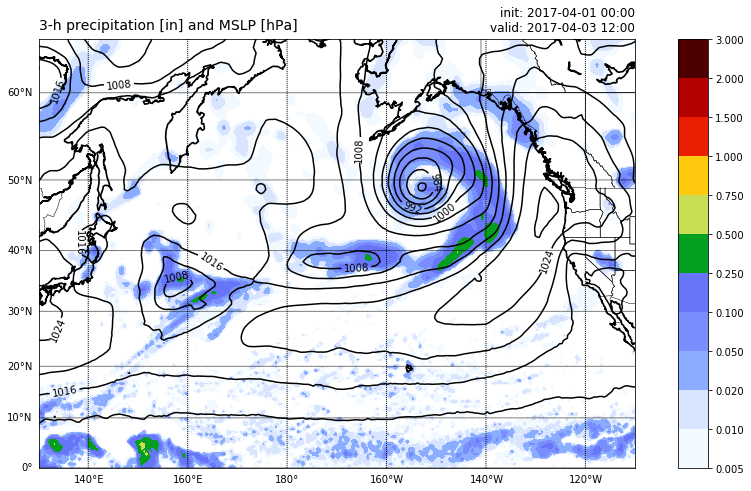

In [9]:
import plotting_mpas_latlon as plotmpas
import warnings
warnings.filterwarnings('ignore')

valid_dt = datetime(2017, 4, 3, 12)
fig, ax, cax, m = plotmpas.draw_fig_axes(proj='mercNP')
plotmpas.plot_precip_mslp(m, ax, cax, mpas_fcst, idate=mpas_fcst.idate, 
                          vdate=valid_dt, swaplons=True)
plt.show()

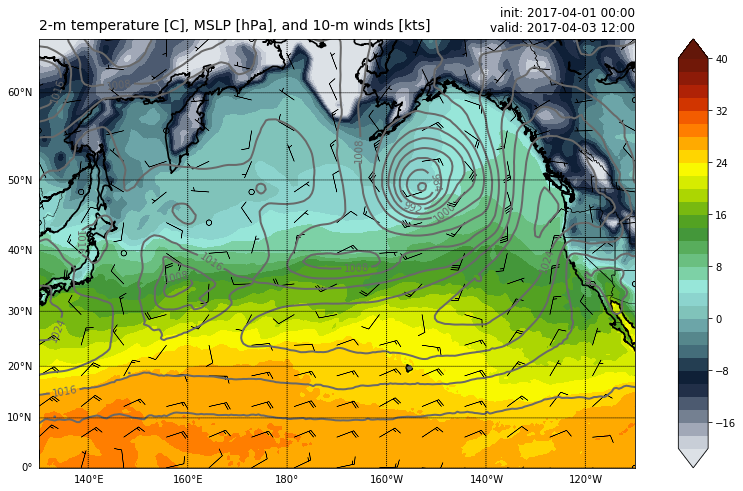

In [10]:
fig, ax, cax, m = plotmpas.draw_fig_axes(proj='mercNP')
plotmpas.plot_t2m_mslp(m, ax, cax, mpas_fcst, idate=mpas_fcst.idate, 
                       vdate=valid_dt, swaplons=True)
plt.show()

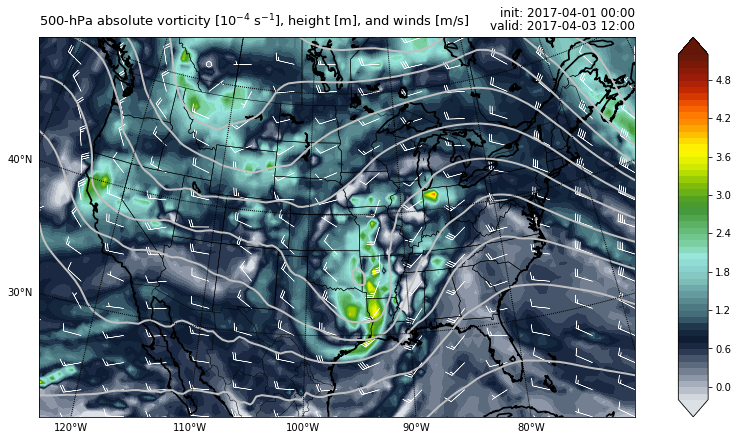

In [11]:
fig, ax, cax, m = plotmpas.draw_fig_axes(proj='stereCONUS')
plotmpas.plot_vort_hgt(m, ax, cax, mpas_fcst, 500, idate=mpas_fcst.idate, vdate=valid_dt)
plt.show()

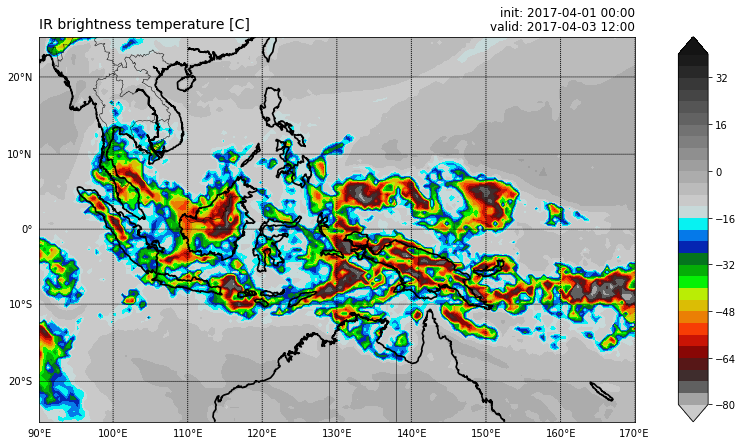

In [12]:
fig, ax, cax, m = plotmpas.draw_fig_axes(proj='mercMC')
plotmpas.plot_brightness_temp(m, ax, cax, mpas_fcst, idate=mpas_fcst.idate, vdate=valid_dt)
plt.show()

Created new variable: "prate1h"


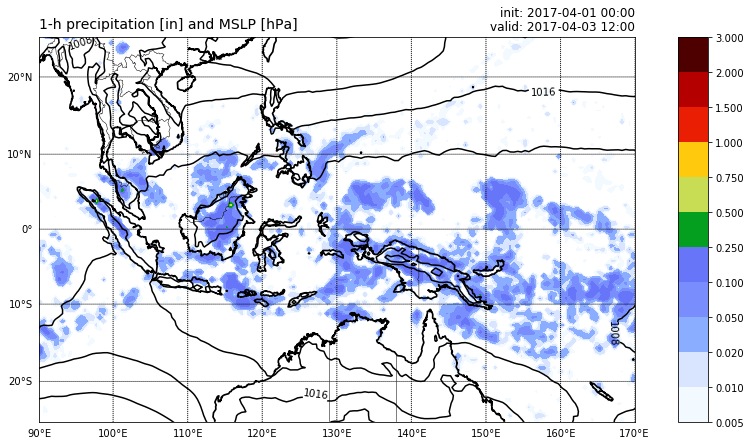

In [13]:
fig, ax, cax, m = plotmpas.draw_fig_axes(proj='mercMC')
plotmpas.plot_precip_mslp(m, ax, cax, mpas_fcst, idate=mpas_fcst.idate, 
                          vdate=valid_dt, swaplons=True, pdt=1)
plt.show()

## Let's look at the mean state over the 4-day forecast

In [14]:
from color_maker.color_maker import color_map
from color_maker.nonlinear_cmap import nlcmap
workdir = '/glade/scratch/njweber2/experiments/24km_4day_20170401'
ncfile = '{}/diags.latlon.nc'.format(workdir)
mpas_fcst = MPASprocessed.from_netcdf(ncfile, datetime(2017,4,1,0), 1)

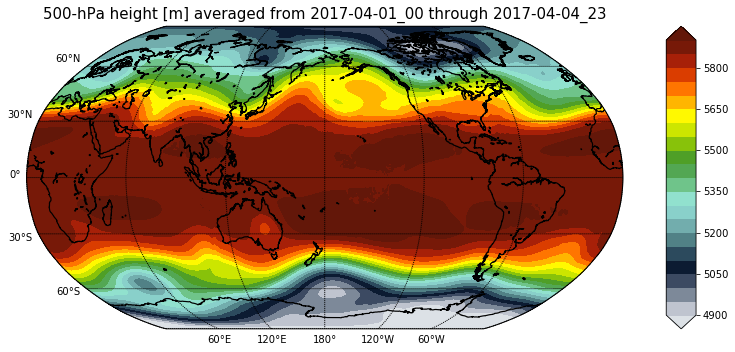

In [15]:
# 500 hPa geopotential height
mean_height = mpas_fcst.compute_timemean('height_500hPa')
fig, ax, cax, m = plotmpas.draw_fig_axes(proj='robinGlobal')
mpas_fcst.restructure_lons()
x, y = mpas_fcst.project_coordinates(m)
cs = m.contourf(x, y, mean_height.values, levels=np.arange(4900, 5901, 50), extend='both',
                cmap=color_map('ncar_temp'))
title = '500-hPa height [m] averaged from {:%Y-%m-%d_%H} through {:%Y-%m-%d_%H}'
ax.text(0.5, 1.01, title.format(mpas_fcst.idate, mpas_fcst.vdates()[-1]), ha='center',
       va='bottom', transform=ax.transAxes, fontsize=15)
plt.colorbar(cs, cax=cax)
plt.show()

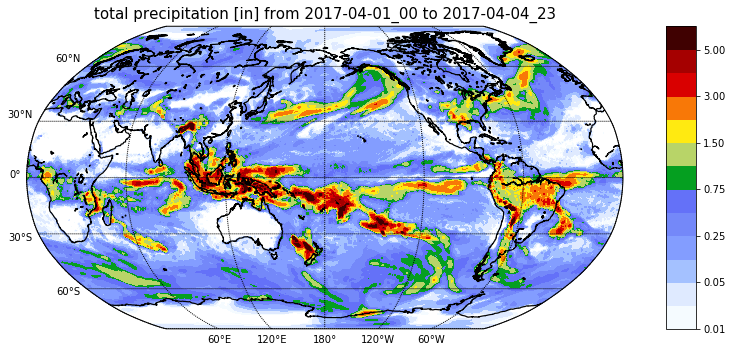

In [16]:
# Total precipitation
precip = (mpas_fcst.get_var('rainc').values + mpas_fcst.get_var('rainnc').values)[-1,:,:]
levels = [.01,.02,.05,.1,.25,.5,.75,1.,1.5,2.,3.,4.,5.,10.]
cmap = nlcmap(color_map('ncar_precip'), levels)
fig, ax, cax, m = plotmpas.draw_fig_axes(proj='robinGlobal')
cs = m.contourf(x, y, precip*0.0393701, levels=levels, cmap=cmap)
title = 'total precipitation [in] from {:%Y-%m-%d_%H} to {:%Y-%m-%d_%H}'
ax.text(0.5, 1.01, title.format(mpas_fcst.idate, mpas_fcst.vdates()[-1]), ha='center',
       va='bottom', transform=ax.transAxes, fontsize=15)
plt.colorbar(cs, cax=cax)
plt.show()